## 3. Quantum Combinatorial Optimization

### 3.1 Quantum Approximated Optimization Algorithm

#### Quadratic Unconstrained Binary Optimization (QUBO)

$$
\underset{x \in \{0,1\}^{\otimes n}}{\min}  x^t Q x + \beta^t x \equiv \sum_{i} \sum_{j} q_{ij}x_i x_j + \sum_{i} x_i 
$$

In [1]:
from dimod import ConstrainedQuadraticModel, Integer, QuadraticModel
from dwave.system import LeapHybridCQMSampler
import os
### QAOA_realestate가 있는 폴더로 지정
# dir_path = "/Users/minhyeong-gyu/Documents/GitHub/QUANTUM_TUTORIAL"
dir_path = "C:/Users/mhg95/Documents/GitHub/QUANTUM_TUTORIAL"
os.chdir(dir_path)
import sys
module_path = dir_path + "/Module"
if module_path not in sys.path:
    sys.path.append(module_path)

from optimizer import optimizer as opt
from optimizer import basefunctions as bf

import numpy as np
%matplotlib inline

In [2]:
def draw_graph(G, cluster, pos,size = 600):
    clt1 = np.array([i for i in range(n)])[cluster==1.0]
    clt2 = np.array([i for i in range(n)])[cluster!=1.0]
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, nodelist=clt1,node_color="tab:red", node_size=size, alpha=0.8, ax=default_axes, pos=pos)
    nx.draw_networkx(G, nodelist=clt2,node_color="tab:blue", node_size=size, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [3]:
Q = np.array([[1,2,3],[4,5,6],[7,8,9]])
beta = np.array([-3,-2,-1])

In [4]:
from qiskit_optimization import QuadraticProgram
p = len(Q)
mod = QuadraticProgram()
linear = {"x" + str(i) : beta[i] for i in range(p)}
quadratic = {("x"+str(i),"x"+str(j)):Q[i,j] for i in range(p) for j in range(p)}
for i in range(p):
    mod.binary_var(name = "x"+str(i))
mod.minimize(linear = linear , quadratic = quadratic)
print(mod.prettyprint())

Problem name: 

Minimize
  x0^2 + 6*x0*x1 + 10*x0*x2 + 5*x1^2 + 14*x1*x2 + 9*x2^2 - 3*x0 - 2*x1 - x2

Subject to
  No constraints

  Binary variables (3)
    x0 x1 x2



In [5]:
from qiskit.providers.aer import QasmSimulator
from qiskit.utils import QuantumInstance
backend = QasmSimulator()
quantum_instance = QuantumInstance(backend)

In [6]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
repeat = 2
solver = QAOA(quantum_instance=quantum_instance,reps = repeat)
optimizer = MinimumEigenOptimizer(solver)
result = optimizer.solve(mod)

In [7]:
result.x

array([1., 0., 0.])

In [8]:
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(solver)
result = optimizer.solve(mod)

In [9]:
result.x

array([1., 0., 0.])

### 3.2 Maxcut Problem

In [10]:
def draw_graph(G, cluster, pos,size = 600):
    clt1 = np.array([i for i in range(n)])[cluster==1.0]
    clt2 = np.array([i for i in range(n)])[cluster!=1.0]
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, nodelist=clt1,node_color="tab:red", node_size=size, alpha=0.8, ax=default_axes, pos=pos)
    nx.draw_networkx(G, nodelist=clt2,node_color="tab:blue", node_size=size, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [11]:
from itertools import combinations
n=10
comb_item = list(combinations(range(n), 2))
random_index = np.random.randint(1,n*(n-1)/2,3*n)
random_edge = np.array(comb_item)[random_index]

[[0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [1. 1. 0. 0. 1. 0. 0. 0. 1. 1.]
 [1. 1. 0. 1. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 0. 1. 1. 0.]]


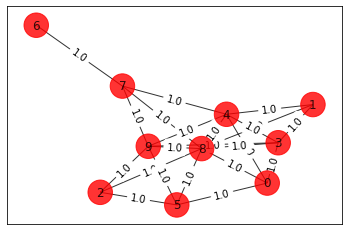

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
n = 10  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

comb_item = list(combinations(range(n), 2))
random_index = np.random.randint(1,n*(n-1)/2,3*n)
random_edge = np.array(comb_item)[random_index]
elist = [tuple(random_edge[i].tolist() + [1.0]) for i in range(3*n)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

In [13]:
from qiskit_optimization.applications import Maxcut
max_cut = Maxcut(w)
mod = max_cut.to_quadratic_program()
print(mod.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_3 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_0*x_8 - 2*x_1*x_3 - 2*x_1*x_4
  - 2*x_1*x_8 - 2*x_2*x_5 - 2*x_2*x_8 - 2*x_2*x_9 - 2*x_3*x_4 - 2*x_3*x_8
  - 2*x_3*x_9 - 2*x_4*x_7 - 2*x_4*x_8 - 2*x_4*x_9 - 2*x_5*x_8 - 2*x_5*x_9
  - 2*x_6*x_7 - 2*x_7*x_8 - 2*x_7*x_9 - 2*x_8*x_9 + 4*x_0 + 3*x_1 + 3*x_2
  + 5*x_3 + 6*x_4 + 4*x_5 + x_6 + 4*x_7 + 8*x_8 + 6*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9



In [14]:
repeat = 2
solver = QAOA(quantum_instance=quantum_instance,reps = repeat)
optimizer = MinimumEigenOptimizer(solver)
result = optimizer.solve(mod)
result.x

array([0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])

In [15]:
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(solver)
result = optimizer.solve(mod)
result.x

array([0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])

### 3.3 Travelling Sales Mans Problem

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


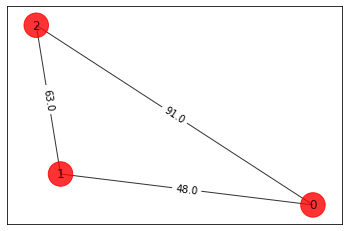

In [16]:
from qiskit_optimization.applications import Tsp

# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [17]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [18]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
mod = qp2qubo.convert(qp)

In [19]:
repeat = 3
solver = QAOA(quantum_instance=quantum_instance,reps = repeat)
optimizer = MinimumEigenOptimizer(solver)
result = optimizer.solve(mod)
result.x

array([1., 0., 0., 0., 0., 1., 0., 1., 0.])

In [20]:
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
optimizer = MinimumEigenOptimizer(solver)
result = optimizer.solve(mod)
result.x

array([1., 0., 0., 0., 1., 0., 0., 0., 1.])

### DWAVE device


In [21]:
my_api_token = "yXwP-f2aec33bfee8942f29378398525e5bb738779590"
sampler = LeapHybridCQMSampler(token = my_api_token)


In [22]:
def get_qb_from_adj(w):
    Q = -2*w
    beta = sum(w)
    return Q,beta
Q,beta = get_qb_from_adj(w)

In [23]:
opt_dwave = opt.DWAVE_optimizer(sampler)
opt_sa = opt.SimulatedAnnealing()

In [24]:
opt_dwave.optimize(-Q,-beta)

In [25]:
opt_sa.optimize(-Q,-beta)

C:/Users/mhg95/Documents/GitHub/QUANTUM_TUTORIAL/Module\optimizer\optimizer.py:82: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((obj(theta_temp, Q = Q, beta = beta, lmbd = lamda)-obj(theta_star, Q = Q, beta = beta, lmbd = lamda))/tau)):


array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])

In [26]:
opt_dwave.result

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [27]:
opt_sa.result

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1.])

In [ ]:
n = 200  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

comb_item = list(combinations(range(n), 2))
random_index = np.random.randint(1,n*(n-1)/2,3*n)
random_edge = np.array(comb_item)[random_index]

elist = [tuple(random_edge[i].tolist() + [1.0]) for i in range(3*n)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

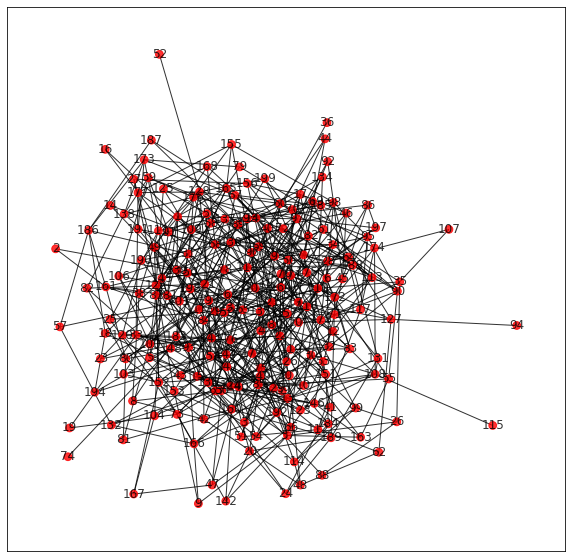

In [45]:
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
fig = plt.figure(figsize = (10,10))
draw_graph(G, colors, pos,size=60)
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

In [36]:
import time
Q,beta = get_qb_from_adj(w)

In [37]:
start = time.time()
opt_sa.optimize(-Q,-beta)
time_sa = time.time()-start 

start = time.time()
opt_dwave.optimize(-Q,-beta)
time_dwave = time.time()-start

C:/Users/mhg95/Documents/GitHub/QUANTUM_TUTORIAL/Module\optimizer\optimizer.py:82: RuntimeWarning: overflow encountered in exp
  if np.random.rand(1) <= min(1, np.exp((obj(theta_temp, Q = Q, beta = beta, lmbd = lamda)-obj(theta_star, Q = Q, beta = beta, lmbd = lamda))/tau)):


In [38]:
x = np.array(opt_dwave.result)
score_dwave = x@Q@x.T+beta@x.T
x = np.array(opt_sa.result)
score_sa = x@Q@x.T+beta@x.T

In [39]:
print("Score :",score_dwave,", Operation Time :",time_dwave)

Score : 412.0 , Operation Time : 16.657336711883545


In [40]:
print("Score :",score_sa,", Operation Time :",time_sa)

Score : 395.0 , Operation Time : 6.833550214767456


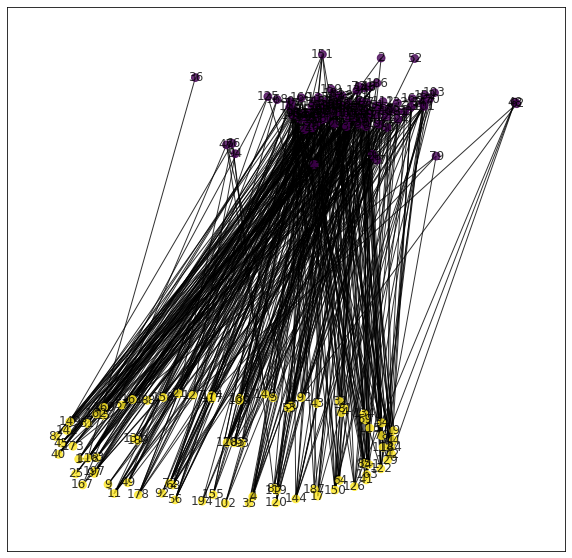

In [41]:
label = np.array(opt_sa.result)
partition = {i:label[i] for i in range(len(label))}
pos = community_layout(G,partition)
fig = plt.figure(figsize=(10,10))
draw_graph(G,label, pos,size = 60)

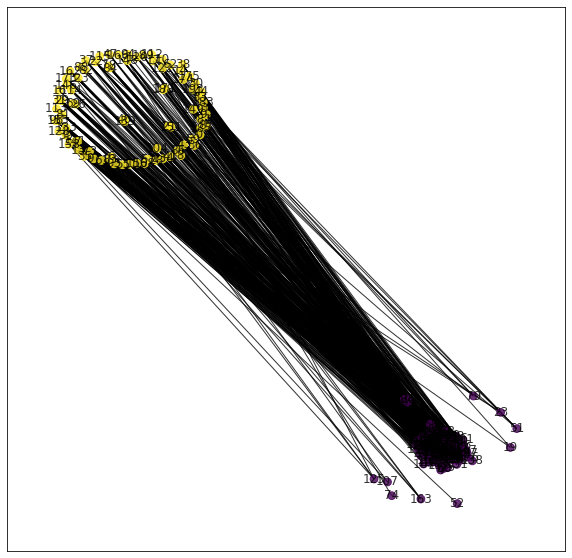

In [42]:
label = np.array(opt_dwave.result)
partition = {i:label[i] for i in range(len(label))}
pos = community_layout(G,partition)
fig = plt.figure(figsize=(10,10))
draw_graph(G,label, pos,size = 60)